The aim of this project is to identify the toxicity in tweets.For the sake of simplicity, we say a tweet contains toxicity if it has a sentiment associated with it. So, the task is to classify such toxic tweets from other tweets.
• Understand the Problem Statement

• Tweets Preprocessing and Cleaning

• Data Inspection

• Data Cleaning

• Story Generation and Visualization from Tweets

• Extracting Features from Cleaned Tweets

• Bag-of-Words

• TF-IDF

• Word Embeddings

• Model Building: Sentiment Analysis

• Logistic Regression

• Support Vector Machine

• RandomForest

• XGBoost

• Model Fine-tuning

• Summary

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

In [0]:
train=pd.read_csv('/content/gdrive/My Drive/twitter_train.csv')

In [0]:
test=pd.read_csv('/content/gdrive/My Drive/twitter_test.csv')

In [34]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [35]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [39]:
train.shape,test.shape

((31962, 3), (17197, 2))

In [36]:
train[train.label==0].head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [37]:
train[train.label==1].head(10)

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk fol...
77,78,1,"@user hey, white people: you can call people '..."
82,83,1,how the #altright uses &amp; insecurity to lu...
111,112,1,@user i'm not interested in a #linguistics tha...


In [38]:
train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In the train dataset we have 2242 (approx 7%) tweets labeled as racist or sexist and 29720 (aprrox 93 %) tweets labeled as non racist/sexist. So, it is an imbalance classification challenge.

In [40]:
print("Percentage of people who are identified as rasict are approx",round((2242/(29720+2242))*100),'%')
print("Percentage of people who are identified as non-rasict are approx",round((29720/(29720+2242))*100),'%')

Percentage of people who are identified as rasict are approx 7 %
Percentage of people who are identified as non-rasict are approx 93 %


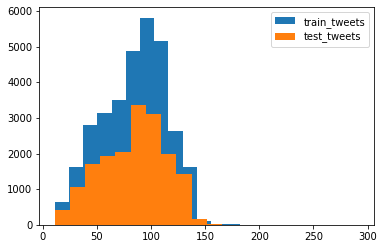

In [41]:
length_train=train['tweet'].str.len()
length_test=test['tweet'].str.len()
plt.hist(length_train,bins=20,label='train_tweets')
plt.hist(length_test,bins=20,label='test_tweets')
plt.legend()
plt.show()

In [42]:
combi=train.append(test,ignore_index=True)
combi.shape

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


(49159, 3)

The given below function is used to remove the Unwanted text patterns from tweets.

In [0]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'', input_txt)
    return input_txt


We will be following the steps below to clean the raw tweets in out data.

1) We will remove the twitter handles as they are already masked as @user due to privacy concerns. These twitter handles hardly give any information about the nature of the tweet.

2) We will also get rid of the punctuations, numbers and even special characters since they wouldn’t help in differentiating different types of tweets.

3) Most of the smaller words do not add much value. For example, ‘pdx’, ‘his’, ‘all’. So, we will try to remove them as well from our data.

4) Lastly, we will normalize the text data. For example, reducing terms like loves, loving, and lovable to their base word, i.e., ‘love’.are often used in the same context. If we can reduce them to their root word, which is ‘love’. It will help in reducing the total number of unique words in our data without losing a significant amount of information.

Removing Twitter Handles (@user)
Let’s create a new column tidy_tweet, it will contain the cleaned and processed tweets. Note that we have passed “@[]*” as the pattern to the remove_pattern function. It is actually a regular expression which will pick any word starting with ‘@’.

In [46]:
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'],"@[\w]*")
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


Removing Punctuations, Numbers, and Special Characters
Here we will replace everything except characters and hashtags with spaces. The regular expression “[^a-zA-Z#]” means anything except alphabets and ‘#’.

In [47]:
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
combi.head(10)

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can t use cause th...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide society now #motivation
5,6,0.0,[2/2] huge fan fare and big talking before the...,huge fan fare and big talking before the...
6,7,0.0,@user camping tomorrow @user @user @user @use...,camping tomorrow danny
7,8,0.0,the next school year is the year for exams.ð...,the next school year is the year for exams ...
8,9,0.0,we won!!! love the land!!! #allin #cavs #champ...,we won love the land #allin #cavs #champ...
9,10,0.0,@user @user welcome here ! i'm it's so #gr...,welcome here i m it s so #gr



Removing Short Words
We have to be a little careful here in selecting the length of the words which we want to remove. So, I have decided to remove all the words having length 3 or less. For example, terms like “hmm”, “oh” are of very little use. It is better to get rid of them.

In [0]:
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [49]:
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation



You can see the difference between the raw tweets and the cleaned tweets (tidy_tweet) quite clearly. Only the important words in the tweets have been retained and the noise (numbers, punctuations, and special characters) has been removed.

Text Normalization
Here we will use nltk’s PorterStemmer() function to normalize the tweets. But before that we will have to tokenize the tweets. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.

In [50]:
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split()) # tokenizing 
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

In [52]:
from nltk.stem.porter import * 
stemmer = PorterStemmer() 
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

In [0]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])    
combi['tidy_tweet'] = tokenized_tweet

In this section, we will explore the cleaned tweets. Exploring and visualizing data, no matter whether its text or any other data, is an essential step in gaining insights.

Before we begin exploration, we must think and ask questions related to the data in hand. A few probable questions are as follows:

What are the most common words in the entire dataset? What are the most common words in the dataset for negative and positive tweets, respectively? How many hashtags are there in a tweet? Which trends are associated with my dataset? Which trends are associated with either of the sentiments? Are they compatible with the sentiments?

A) Understanding the common words used in the tweets: WordCloud

Now I want to see how well the given sentiments are distributed across the train dataset. One way to accomplish this task is by understanding the common words by plotting wordclouds.

A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.

Let’s visualize all the words our data using the wordcloud plot.

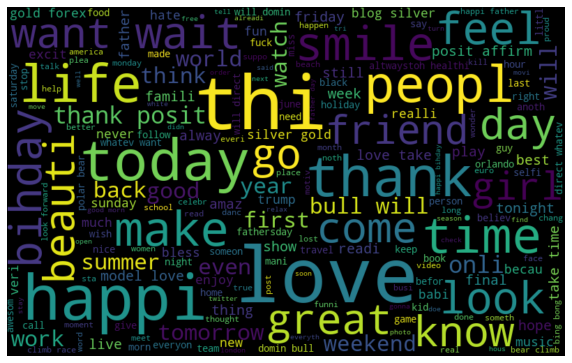

In [54]:
import wordcloud
from wordcloud import WordCloud

all_words = ' '.join([text for text in combi['tidy_tweet']])  
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

We can see most of the words are positive or neutral. Words like love, great, friend, life are the most frequent ones. It doesn’t give us any idea about the words associated with the racist/sexist tweets. Hence, we will plot separate wordclouds for both the classes (racist/sexist or not) in our train data.

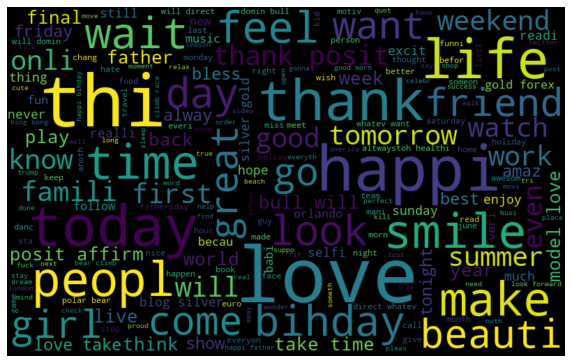

In [55]:
normal_words =' '.join([text for text in combi['tidy_tweet'][combi['label'] == 0]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


Most of the frequent words are compatible with the sentiment, i.e, non-racist/sexists tweets. Similarly, we will plot the word cloud for the other sentiment. Expect to see negative, racist, and sexist terms.

Racist or sexist tweets

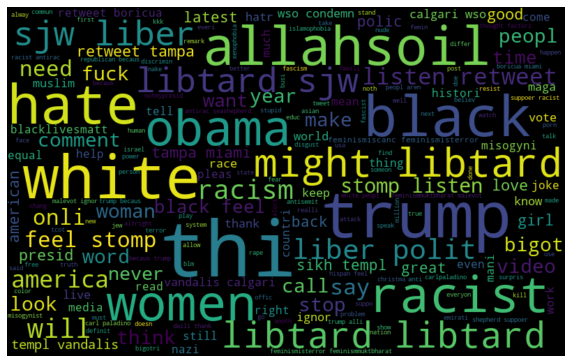

In [56]:
negative_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


As we can clearly see, most of the words have negative connotations. So, it seems we have a pretty good text data to work on. Next we will the hashtags/trends in our twitter data.

D) Understanding the impact of Hashtags on tweets sentiment

Hashtags in twitter are synonymous with the ongoing trends on twitter at any particular point in time. We should try to check whether these hashtags add any value to our sentiment analysis task, i.e., they help in distinguishing tweets into the different sentiments.

For instance, given below is a tweet from our dataset:

The tweet seems sexist in nature and the hashtags in the tweet convey the same feeling.

We will store all the trend terms in two separate lists — one for non-racist/sexist tweets and the other for racist/sexist tweets.

In [0]:
# function to collect hashtags 
def hashtag_extract(x):
    hashtags = []
# Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

In [0]:

# extracting hashtags from non racist/sexist tweets 
HT_regular = hashtag_extract(combi['tidy_tweet'][combi['label'] == 0]) 
# extracting hashtags from racist/sexist tweets 
HT_negative = hashtag_extract(combi['tidy_tweet'][combi['label'] == 1]) 
# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])


Now that we have prepared our lists of hashtags for both the sentiments, we can plot the top ‘n’ hashtags. So, first let’s check the hashtags in the non-racist/sexist tweets.

Non-Racist/Sexist Tweets

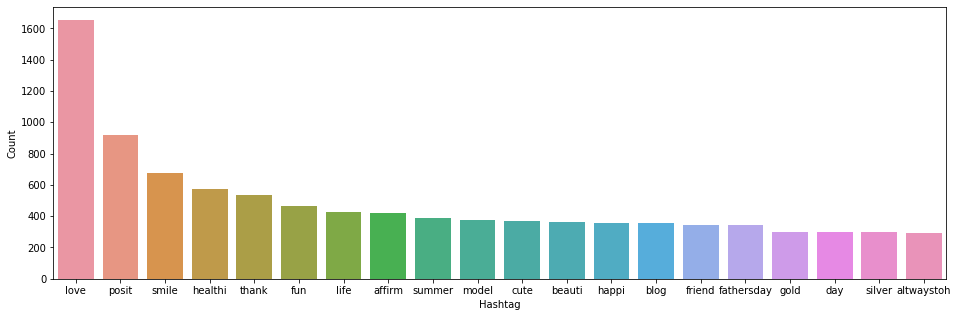

In [61]:

a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),'Count': list(a.values())}) 
# selecting top 20 most frequent hashtags
d = d.nlargest(columns="Count", n = 20)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

All these hashtags are positive and it makes sense. I am expecting negative terms in the plot of the second list. Let’s check the most frequent hashtags appearing in the racist/sexist tweets.

Racist/Sexist Tweets

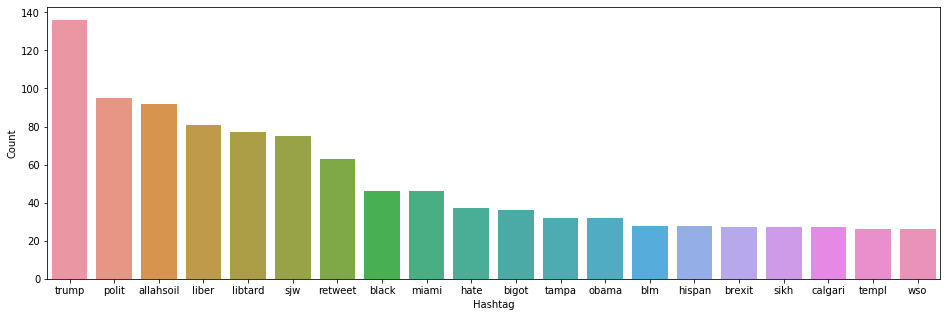

In [62]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())}) 
# selecting top 20 most frequent hashtags
e = e.nlargest(columns="Count", n = 20)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")


As expected, most of the terms are negative with a few neutral terms as well. So, it’s not a bad idea to keep these hashtags in our data as they contain useful information. Next, we will try to extract features from the tokenized tweets.

To analyse a preprocessed data, it needs to be converted into features. Depending upon the usage, text features can be constructed using assorted techniques – Bag of Words, TF-IDF, and Word Embeddings. Read on to understand these techniques in detail.

In [0]:
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


Let’s start with the Bag-of-Words Features.

Consider a Corpus C of D documents {d1,d2…..dD} and N unique tokens extracted out of the corpus C. The N tokens (words) will form a dictionary and the size of the bag-of-words matrix M will be given by D X N. Each row in the matrix M contains the frequency of tokens in document D(i).

Let us understand this using a simple example.

D1: He is a lazy boy. She is also lazy.

D2: Smith is a lazy person.

The dictionary created would be a list of unique tokens in the corpus =[‘He’,’She’,’lazy’,’boy’,’Smith’,’person’]

Here, D=2, N=6

Now the columns in the above matrix can be used as features to build a classification model.

In [65]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])
bow.shape

(49159, 1000)


This is another method which is based on the frequency method but it is different to the bag-of-words approach in the sense that it takes into account not just the occurrence of a word in a single document (or tweet) but in the entire corpus.

TF-IDF works by penalising the common words by assigning them lower weights while giving importance to words which are rare in the entire corpus but appear in good numbers in few documents.

Let’s have a look at the important terms related to TF-IDF:

TF = (Number of times term t appears in a document)/(Number of terms in the document)

IDF = log(N/n), where, N is the number of documents and n is the number of documents a term t has appeared in.

TF-IDF = TF*IDF

In [66]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english') 
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])
tfidf.shape

(49159, 1000)

In [0]:
# desired no. of features/independent variables
# context window size
# for negative sampling
# no.of cores
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split()) # tokenizing 
model_w2v = gensim.models.Word2Vec(tokenized_tweet, size=200, window=5, min_count=2, sg = 1, hs = 0, negative = 10, workers= 2, seed = 34)

In [68]:
model_w2v.train(tokenized_tweet, total_examples= len(combi['tidy_tweet']), epochs=20)

(6510903, 7536020)

In [69]:
model_w2v.wv.most_similar(positive="dinner")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('spaghetti', 0.5849555730819702),
 ('#cellar', 0.5629631280899048),
 ('#burrito', 0.549676775932312),
 ('#foodcoma', 0.5468052625656128),
 ('enrout', 0.5454554557800293),
 ('burrito', 0.5439980626106262),
 ('spinach', 0.54068523645401),
 ('#biall', 0.5397946834564209),
 ('cookout', 0.5379639863967896),
 ('#pasta', 0.5369489789009094)]

In [102]:
model_w2v.wv.most_similar(positive="trump")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('donald', 0.5675158500671387),
 ('hillari', 0.5456408858299255),
 ('phoni', 0.5435616970062256),
 ('#delegaterevolt', 0.5412265062332153),
 ('unfavor', 0.537018358707428),
 ('unstabl', 0.5297373533248901),
 ('nomine', 0.526038646697998),
 ('jibe', 0.5258172750473022),
 ('tomlin', 0.5252389907836914),
 ('businessman', 0.5241383910179138)]

In [70]:
model_w2v['food'][:20]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-0.28766185,  0.15290526,  0.7112264 ,  0.29471314,  0.18159354,
       -0.20055707,  0.03754295, -0.25055063, -0.66689575, -0.09002661,
       -0.7739794 ,  1.0567262 ,  0.21282664, -0.39909807, -0.20289777,
       -0.46291813, -0.21490967,  0.08465572, -0.10146254,  0.15129909],
      dtype=float32)

In [103]:
len(model_w2v['food'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


200


Preparing Vectors for Tweets

Since our data contains tweets and not just words, we’ll have to figure out a way to use the word vectors from word2vec model to create vector representation for an entire tweet. There is a simple solution to this problem, we can simply take mean of all the word vectors present in the tweet. The length of the resultant vector will be the same, i.e. 200. We will repeat the same process for all the tweets in our data and obtain their vectors. Now we have 200 word2vec features for our data.

We will use the below function to create a vector for each tweet by taking the average of the vectors of the words present in the tweet.

In [0]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary                                    
            continue
    if count != 0:
        vec /= count
    return vec

In [105]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(49159, 200)


Now we have 200 new features, whereas in Bag of Words and TF-IDF we had 1000 features.

Doc2Vec Embedding
Doc2Vec model is an unsupervised algorithm to generate vectors for sentence/paragraphs/documents. This approach is an extension of the word2vec. The major difference between the two is that doc2vec provides an additional context which is unique for every document in the corpus. This additional context is nothing but another feature vector for the whole document. This document vector is trained along with the word vectors.

Let’s load the required libraries

In [0]:
from gensim.models.doc2vec import LabeledSentence

In [0]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

In [112]:
labeled_tweets = add_label(tokenized_tweet)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  after removing the cwd from sys.path.


In [113]:

model_d2v = gensim.models.Doc2Vec(dm=1, dm_mean=1, size=200, window=5, negative=7,min_count=5,workers=3,alpha=0.1,seed = 23)

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [114]:
model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])

model_d2v.train(labeled_tweets, total_examples= len(combi['tidy_tweet']), epochs=15)

100%|██████████| 49159/49159 [00:00<00:00, 2814504.57it/s]


In [115]:
docvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(combi)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,200))    

docvec_df = pd.DataFrame(docvec_arrays) 
docvec_df.shape

(49159, 200)


We are now done with all the pre-modeling stages required to get the data in the proper form and shape. We will be building models on the datasets with different feature sets prepared in the earlier sections — Bag-of-Words, TF-IDF, word2vec vectors, and doc2vec vectors. We will use the following algorithms to build models:

Logistic Regression Support Vector Machine RandomForest XGBoost Evaluation Metric

F1 score is being used as the evaluation metric. It is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. It is suitable for uneven class distribution problems.

The important components of F1 score are:

True Positives (TP) - These are the correctly predicted positive values which means that the value of actual class is yes and the value of predicted class is also yes. True Negatives (TN) - These are the correctly predicted negative values which means that the value of actual class is no and value of predicted class is also no. False Positives (FP) – When actual class is no and predicted class is yes. False Negatives (FN) – When actual class is yes but predicted class in no. Precision = TP/TP+FP

Recall = TP/TP+FN

F1 Score = 2(Recall Precision) / (Recall + Precision)

Bag-of-Words Features

We will first try to fit the logistic regression model on the Bag-of_Words (BoW) features.

In [116]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Extracting train and test BoW features 
train_bow = bow[:31962,:]
test_bow = bow[31962:,:] 
# splitting data into training and validation set 
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'],random_state=42,test_size=0.3)
lreg = LogisticRegression() 
# training the model
lreg.fit(xtrain_bow, ytrain) 
prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set 
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int) # calculating f1 score for the validation set

0.5303408146300915

In [0]:
#Now let’s make predictions for the test dataset and create a submission file.

test_pred = lreg.predict_proba(test_bow) 
test_pred_int = test_pred[:,1] >= 0.3 
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int 
submission = test[['id','label']] 
submission.to_csv('sub_lreg_bow.csv', index=False) # writing data to a CSV file


TF-IDF Features

We’ll follow the same steps as above, but now for the TF-IDF feature set.

In [118]:

train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:] 
xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]
lreg.fit(xtrain_tfidf, ytrain) 
prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int) # calculating f1 score for the validation set

0.5451327433628319

Word2Vec Features

In [119]:
train_w2v = wordvec_df.iloc[:31962,:]
test_w2v = wordvec_df.iloc[31962:,:] 
xtrain_w2v = train_w2v.iloc[ytrain.index,:]
xvalid_w2v = train_w2v.iloc[yvalid.index,:]
lreg.fit(xtrain_w2v, ytrain) 
prediction = lreg.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

0.6252804786836201

Doc2Vec Features

In [120]:
train_d2v = docvec_df.iloc[:31962,:]
test_d2v = docvec_df.iloc[31962:,:] 
xtrain_d2v = train_d2v.iloc[ytrain.index,:]
xvalid_d2v = train_d2v.iloc[yvalid.index,:]
lreg.fit(xtrain_d2v, ytrain) 
prediction = lreg.predict_proba(xvalid_d2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

0.3653516295025729


Doc2Vec features do not seem to be capturing the right signals as the F1-scores on validation are quite low.

Support Vector Machine (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. However, it is mostly used in classification problems. In this algorithm, we plot each data item as a point in n-dimensional space (where n is the number of features you have) with the value of each feature being the value of a particular coordinate. Then, we perform classification by finding the hyper-plane that differentiate the two classes as shown in the plot below:

Bag-of-Words Features

In [121]:
from sklearn import svm
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_bow, ytrain) 
prediction = svc.predict_proba(xvalid_bow) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)

0.5083179297597042

Again let’s make predictions for the test dataset and create another submission file.

In [0]:
test_pred = svc.predict_proba(test_bow) 
test_pred_int = test_pred[:,1] >= 0.3 
test_pred_int = test_pred_int.astype(np.int) 
test['label'] = test_pred_int 
submission = test[['id','label']] 
submission.to_csv('sub_svm_bow.csv', index=False)

Here both validation score and leaderboard score are slightly lesser than the Logistic Regression scores for bag-of-words features.

TF-IDF Features

In [123]:
svc = svm.SVC(kernel='linear', 
C=1, probability=True).fit(xtrain_tfidf, ytrain) 
prediction = svc.predict_proba(xvalid_tfidf) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)

0.5109489051094891


Word2Vec Features

In [124]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_w2v, ytrain) 
prediction = svc.predict_proba(xvalid_w2v) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

0.6171875

Doc2Vec Features

In [125]:
 svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_d2v, ytrain) 
prediction = svc.predict_proba(xvalid_d2v) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)

0.21147356580427448

Random Forest is a versatile machine learning algorithm capable of performing both regression and classification tasks. It is a kind of ensemble learning method, where a few weak models combine to form a powerful model. In Random Forest, we grow multiple trees as opposed to a decision single tree. To classify a new object based on attributes, each tree gives a classification and we say the tree “votes” for that class. The forest chooses the classification having the most votes (over all the trees in the forest).

It works in the following manner. Each tree is planted & grown as follows:

Assume number of cases in the training set is N. Then, sample of these N cases is taken at random but with replacement. This sample will be the training set for growing the tree.

If there are M input variables, a number m (m<M) is specified such that at each node, m variables are selected at random out of the M. The best split on these m variables is used to split the node. The value of m is held constant while we grow the forest.

Each tree is grown to the largest extent possible and there is no pruning.

Predict new data by aggregating the predictions of the ntree trees (i.e., majority votes for classification, average for regression).

Bag-of-Words Features

First we will train our RandomForest model on the Bag-of-Words features and check its performance on both validation set and public leaderboard.

In [126]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_bow, ytrain) 
prediction = rf.predict(xvalid_bow) 
# validation score
f1_score(yvalid, prediction)

0.5529225908372828

Let’s make predictions for the test dataset and create another submission file.

In [0]:
test_pred = rf.predict(test_bow)
test['label'] = test_pred
submission = test[['id','label']]
submission.to_csv('sub_rf_bow.csv', index=False)

TF-IDF Features

In [128]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_tfidf, ytrain) 
prediction = rf.predict(xvalid_tfidf)
f1_score(yvalid, prediction)

0.562152133580705


Word2Vec Features

In [129]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_w2v, ytrain) 
prediction = rf.predict(xvalid_w2v)
f1_score(yvalid, prediction)

0.5128755364806867

Doc2Vec Features

In [130]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_d2v, ytrain) 
prediction = rf.predict(xvalid_d2v)
f1_score(yvalid, prediction)

0.06232294617563739

Extreme Gradient Boosting (xgboost) is an advanced implementation of gradient boosting algorithm. It has both linear model solver and tree learning algorithms. Its ability to do parallel computation on a single machine makes it extremely fast. It also has additional features for doing cross validation and finding important variables. There are many parameters which need to be controlled to optimize the model.

Some key benefits of XGBoost are:

Regularization - helps in reducing overfitting

Parallel Processing - XGBoost implements parallel processing and is blazingly faster as compared to GBM.

Handling Missing Values - It has an in-built routine to handle missing values.

Built-in Cross-Validation - allows user to run a cross-validation at each iteration of the boosting process

Bag-of-Words Features

In [131]:

import xgboost
from xgboost import XGBClassifier
xgb_model = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_bow, ytrain)
prediction = xgb_model.predict(xvalid_bow)
f1_score(yvalid, prediction)

0.5130687318489837

In [0]:
stest_pred = xgb_model.predict(test_bow)
test['label'] = test_pred
submission = test[['id','label']]
submission.to_csv('sub_xgb_bow.csv', index=False)


TF-IDF Features

In [133]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_tfidf, ytrain) 
prediction = xgb.predict(xvalid_tfidf)
f1_score(yvalid, prediction)

0.5185891325071497


Word2Vec Features

In [134]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_w2v, ytrain) 
prediction = xgb.predict(xvalid_w2v)
f1_score(yvalid, prediction)

0.6449864498644986

XGBoost model on word2vec features has outperformed all the previuos models.

Doc2Vec Features

In [135]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_d2v, ytrain) 
prediction = xgb.predict(xvalid_d2v)
f1_score(yvalid, prediction)

0.345372460496614


XGBoost with Word2Vec model has given us the best performance so far. Let’s try to tune it further to extract as much from it as we can. XGBoost has quite a many tuning parameters and sometimes it becomes tricky to properly tune them. This is what we are going to do in the following steps.

Here we will use DMatrices. A DMatrix can contain both the features and the target.

In [136]:
import xgboost as xgb

dtrain = xgb.DMatrix(xtrain_w2v, label=ytrain) 
dvalid = xgb.DMatrix(xvalid_w2v, label=yvalid) 
dtest = xgb.DMatrix(test_w2v)
# Parameters that we are going to tune 
params = {
    'objective':'binary:logistic',
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1
 }

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


We will prepare a custom evaluation metric to calculate F1 score.

In [0]:
def custom_eval(preds, dtrain):
    labels = dtrain.get_label().astype(np.int)
    preds = (preds >= 0.3).astype(np.int)
    return [('f1_score', f1_score(labels, preds))]


General Approach for Parameter Tuning

We will follow the steps below to tune the parameters.

Choose a relatively high learning rate. Usually a learning rate of 0.3 is used at this stage.

Tune tree-specific parameters such as max_depth, min_child_weight, subsample, colsample_bytree keeping the learning rate fixed.

Tune the learning rate.

Finally tune gamma to avoid overfitting.

Tuning max_depth and min_child_weight

In [138]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(6,10)
     for min_child_weight in range(5,8)
 ]
max_f1 = 0 # initializing with 0 
best_params = None 
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
     # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
         # Cross-validation
    cv_results = xgb.cv(params,dtrain,feval= custom_eval,num_boost_round=200,maximize=True,seed=16,nfold=5,early_stopping_rounds=10)

CV with max_depth=6, min_child_weight=5
CV with max_depth=6, min_child_weight=6
CV with max_depth=6, min_child_weight=7
CV with max_depth=7, min_child_weight=5
CV with max_depth=7, min_child_weight=6
CV with max_depth=7, min_child_weight=7
CV with max_depth=8, min_child_weight=5
CV with max_depth=8, min_child_weight=6
CV with max_depth=8, min_child_weight=7
CV with max_depth=9, min_child_weight=5
CV with max_depth=9, min_child_weight=6
CV with max_depth=9, min_child_weight=7


In [139]:
# Finding best F1 Score
mean_f1 = cv_results['test-f1_score-mean'].max()
    
boost_rounds = cv_results['test-f1_score-mean'].argmax()    
print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))    
if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (max_depth,min_child_weight) 

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

	F1 Score 0.6769556 for 42 rounds
Best params: 9, 7, F1 Score: 0.6769556


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Now it’s time to wrap-up things. Let’s quickly revisit what we have learned in this course, initially we cleaned our raw text data, then we learned about 4 different types of feature-set that we can extract from any text data, and finally we used these feature-sets to build models for sentiment analysis. Below is a summary table showing F1 scores for different models and feature-sets.